In [2]:
import sys
import os

import pickle
from pickle import Unpickler
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix, save_npz, load_npz, vstack
import numpy as np
# from numba import njit, jit
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

## Часть 1.
#### Собираем матрицу смежности.

Для начала загрузим наш файл с аггрегированными данными постов.

In [4]:
with open("RS_2020-12.pickle", "rb") as f:
    pic = pickle.Unpickler(f).load()

df = pd.DataFrame(pic, columns =['subreddit', 'author', "is_self", "created_utc"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290691 entries, 0 to 290690
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subreddit    290691 non-null  object
 1   author       290691 non-null  object
 2   is_self      290691 non-null  bool  
 3   created_utc  290691 non-null  int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 6.9+ MB


In [5]:
df.shape

(290691, 4)

In [6]:
df.head()

,subreddit,author,is_self,created_utc
0,Cookierun,ElectricalBlueberry,True,1606780808
1,disneyemojiblitz,elliewinks30,True,1606856407
2,whynottho,ElectroCatYT1273,True,1606798744
3,OverlookBayTradingRB,Gamereric21,True,1606859707
4,JLeague,DoaraChan,True,1606860007


Создадим отдельные словари для пользователей и сабреддитов.

In [3]:
def make_dicts(df):
    """
        Make users and subreddits dict. Also commit order of values in dicts in two files.
        :param df: pd.Dataframe
        :return: Map "subreddit_name" -> "subreddit_idx", "user_name" -> "user_idx".
    """
    udf = df.groupby("author")
    sdf = df.groupby("subreddit")
    subreddits_dict = {}
    users_dict = {}
    with open("./subreddits.txt", "w") as f:
        for i, subreddit in enumerate(sdf):
            subreddits_dict[subreddit[0]] = i
            f.write(f"{subreddit[0]}\n")
    with open("./users.txt", "w") as f:
        for i, user in enumerate(udf):
            users_dict[user[0]] = i
            f.write(f"{user[0]}\n")
    return subreddits_dict, users_dict

def read_dicts():
    """
    Fill user dict and subreddit dict from files.
    :return: Map "subreddit_name" -> "subreddit_idx", "user_name" -> "user_idx".
    """
    user_dict = {}
    subreddits_dict = {}
    with open("./users.txt", "r") as f:
        i = 0
        line = f.readline()
        while line:
            user_dict[line.strip()] = i
            i += 1
            line = f.readline()
    with open("./subreddits.txt", "r") as f:
        i = 0
        line = f.readline()
        while line:
            subreddits_dict[line.strip()] = i
            i += 1
            line = f.readline()
    return subreddits_dict, user_dict

def update_dicts(dicts, df):
    """
    Update user and subreddit dicts, if df contains user or subreddit, that is absent in dict.
    """
    subreddits_dict, users_dict = dicts
    udf = df.groupby("author")
    sdf = df.groupby("subreddit")
    for subreddit in sdf:
        if not subreddit[0] in subreddits_dict:
            subreddits_dict[subreddit[0]] = len(subreddits_dict)
    for user in udf:
        if not user[0] in users_dict:
            users_dict[user[0]] = len(users_dict)

А так же словарь, группирующий пользователей по сабреддитам.

In [8]:
def make_subreddit_user_dict(subreddits_dict, users_dict):
    """
        Make aggregation of users in common subreddit
        :param subreddits_dict: Map "subreddit_name" -> "subreddit_idx"
        :param users_dict: Map "user_name" -> "user_idx"
        :return: Map "subreddit_idx" -> {user_idx | user_name in subreddit_name}
    """
    subreddit_user_dict = defaultdict(list)
    sdf = df.groupby("subreddit")
    for subreddit, data in sdf:
        users = data["author"].values
        users = np.unique(users)
        subreddit_user_dict[subreddits_dict[subreddit]] += [users_dict[user] for user in users]
    return subreddit_user_dict

def make_sparse_dict(subreddit_user_dict):
    rows = []
    cols = []
    for i, subreddit in enumerate(subreddit_user_dict):
        subreddit_users = subreddit_user_dict[subreddit]
        rows.extend([subreddit] * len(subreddit_users))
        cols.extend(subreddit_users)
    data = np.ones(len(rows), dtype=np.float32)
    rows = np.array(rows, dtype=np.int32)
    cols = np.array(cols, dtype=np.int32)
    return coo_matrix((data, (rows, cols)))

Последняя функция создаёт разреженную матрицу размера $|Subreddits| \times |Users|$.
Действительно, довольно очевидно, что при таком большом числе пользователей, посты в некотором сабреддите
написала лишь небольшая их часть, а потому хранить их в виде разреженной матрицы довольно выгодно по памяти.

In [9]:
subreddits_dict, users_dict = make_dicts(df)
subreddit_user_dict = make_subreddit_user_dict(subreddits_dict, users_dict)
subreddit_user_dict_coo = make_sparse_dict(subreddit_user_dict)

In [11]:
print("Число уникальных сабреддитов:", subreddit_user_dict_coo.shape[0])
print("Число уникальных пользователей:", subreddit_user_dict_coo.shape[1])

Число уникальных сабреддитов: 40412
Число уникальных пользователей: 110297


Напишем функцию для подсчёта меры Жаккара для определения близости сабреддитов.
Заметим, что в нашей матрице размера $|Subreddits| \times |Users|$ по строкам стоят векторы с 0 и 1, причём
единицы стоят в позиции тех пользователей, которые писали пост в данном сабреддите. Пусть $S_i$ и $S_j$ ---
сабреддиты. Тогда мера Жаккара для них определяется следующим образом:

$
Jakkard(S_i, S_j) = \frac{|S_i \cup S_j|}{|S_i \cap S_j|},
$

где пересечением сабреддитов мы считаем множество общих авторов, а объединением --- соответственно,
объединения множеств авторов. Для эффективной реализации функции остаётся заметить,
что если S_i и S_j представляются как векторы размера $|Users|$ с ноликами и единичками, то
$S_i^TS_j = |S_i \cup S_j|$, а $|S_i \cap S_j| = sum(S_i) + sum(S_j) - S_i^TS_j$ по формуле
включений и исключений.

In [11]:
def adjacency_jakkard(sparse_mapping):
    sizes = sparse_mapping.sum(axis=1, dtype=np.float32)
    intersection = (sparse_mapping @ sparse_mapping.T).tocoo(copy=False)
    sizes_rows = coo_matrix((np.squeeze(np.asarray(sizes[intersection.row])),
                         (intersection.row, intersection.col)), dtype=np.float32)
    sizes_cols = coo_matrix((np.squeeze(np.asarray(sizes[intersection.col])),
                             (intersection.row, intersection.col)), dtype=np.float32)
    adj = coo_matrix((intersection.data / union.data, (intersection.row, intersection.col)))
    return adj


In [ ]:
# DONT RUN IT AGAIN
from scipy.sparse import save_npz

adj = adjacency_jakkard(subreddit_user_dict_coo)
save_npz("adjacency_jakkard", adj)

## Часть вторая
#### Рисуем графы

In [4]:
from scipy.sparse import load_npz
import networkx as nx

adj = load_npz("adjacency_jakkard.npz")

Так как граф огромный, и содержит порядка 40'000 сабреддитов и порядка 120'000 вершин,
нарисовать его целиком невозможно, а если и возможно, это будет нерепрезентативно.

Вместо этого выберем случайные 10 сабреддитов и нарисуем подграф на этих сабреддитах.

In [86]:
subreddits_dict, _ = read_dicts()
subgraph_vertex_cnt = 10
random_ids = np.random.randint(0, len(subreddits_dict), subgraph_vertex_cnt)
random_submatrix = np.zeros((subgraph_vertex_cnt, subgraph_vertex_cnt))
subreddits_dict_keys = list(subreddits_dict.keys())
subreddits_names = []
for i, idx in enumerate(random_ids):
    subreddits_names.append(subreddits_dict_keys[idx])
    column_ids = adj.col[adj.row == idx]
    for j, jdx in enumerate(random_ids):
        if jdx in column_ids:
            random_submatrix[i, j] = adj.data[(adj.row == idx) & (adj.col == jdx)]

subgraph_pd = pd.DataFrame({"subreddit_name": subreddits_names})
subgraph_pd


,subreddit_name
0,SukihanaGoat
1,u_missnemuro
2,u_ThemeParkVets
3,freelanceWriters
4,u_AdamTyson
5,SonyXperia
6,HOSPITAL
7,u_kallen815
8,Tools
9,OHGuns


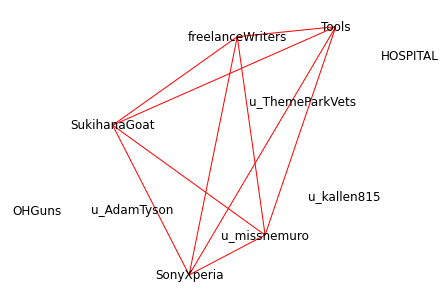

In [96]:
G = nx.from_numpy_matrix(random_submatrix)
plt.figure()
pos = nx.spring_layout(G, iterations=3)
nx.draw(G, pos, node_size=0, edge_color="r", font_size=12,
        linewidths=1,
        labels={k : v for k, v in enumerate(subreddits_names)},
        with_labels=True)
ax = plt.gca()
ax.margins(0.08)
plt.axis('off')
plt.show()

Можно заметить, что так как матрица смежности полного графа у нас довольно разреженная,
то выбирая сабреддиты случайным образом мы редко увидим картину, когда все сабреддиты соединены со всеми.
Чтобы увидеть больше связности, выберем руками сабреддиты с наиболее интересными (и приличными названиями).

In [139]:
chosen_subreddits = [
    "Crypto_Currency_News",
    "MedievalCats",
    "MandelaEffect",
    "CarHacking",
    "AnimeSketch",
    "JapaneseFood",
    "CasualPokemonTrades",
    "GameOfThronesMemes",
    "learnmachinelearning"
]

subreddits_ids = [subreddits_dict[subreddit] for subreddit in chosen_subreddits]
chosen_submatrix = np.zeros((len(subreddits_ids), len(subreddits_ids)))
for i, idx in enumerate(subreddits_ids):
    column_ids = adj.col[adj.row == idx]
    for j, jdx in enumerate(subreddits_ids):
        if jdx in column_ids:
            chosen_submatrix[i, j] = adj.data[(adj.row == idx) & (adj.col == jdx)]

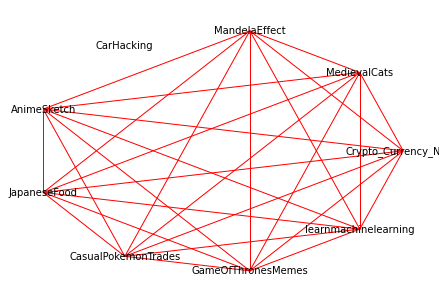

In [140]:
G = nx.from_numpy_matrix(chosen_submatrix)
plt.figure()
pos = nx.circular_layout(G)
nx.draw(G, pos, node_size=0, edge_color="r", font_size=10,
        linewidths=1,
        labels={k : v for k, v in enumerate(chosen_subreddits)},
        with_labels=True)
ax = plt.gca()
ax.margins(0.1)
plt.axis('off')
plt.show()

## Часть 3.
#### Записываем файлики.

In [11]:
# EXTREMLY LARGE FILE
edges_file = pd.DataFrame({"subreddit_idx_1": adj.row,
                           "subreddit_idx_2": adj.col,
                           "jakkard_similarity": adj.data})
edges_file.info()
# edges_file.to_csv("reddit_edges_file.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243685198 entries, 0 to 243685197
Data columns (total 3 columns):
 #   Column              Dtype  
---  ------              -----  
 0   subreddit_idx_1     int32  
 1   subreddit_idx_2     int32  
 2   jakkard_similarity  float32
dtypes: float32(1), int32(2)
memory usage: 2.7 GB


In [10]:
vertex_file = pd.DataFrame({"subreddit_name": subreddits_dict.keys(), "id": np.arange(len(subreddits_dict))})
vertex_file.info()
vertex_file.to_csv("reddit_vertex_file.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40412 entries, 0 to 40411
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subreddit_name  40412 non-null  object
 1   id              40412 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 631.6+ KB


In [5]:
subreddits_dict, _ = read_dicts()